# Wine Recommender System

#### Wine Resources
- wine tasting terms [here](https://winefolly.com/deep-dive/wine-tasting-terms-to-use/)
- a glossary [here](https://sommelierschoiceawards.com/en/blog/insights-1/glossary-of-wine-tasting-terms-and-their-meaning-173.htm)
- the wine aroma wheel [here](https://www.thewinecellarinsider.com/wine-topics/wine-educational-questions/davis-aroma-wheel/)

#### LightFM
- a hybrid recommendation algorithm
- a tool that has the capacity to handle content + collaborative filtering matrices
- found on [here](https://github.com/lyst/lightfm) on github
- use this [link](https://making.lyst.com/lightfm/docs/home.html) for help

# Import Data

In [1]:
# import packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import string
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics import pairwise_distances
from gensim import corpora, matutils
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from corextopic import corextopic as ct
import scipy
from scipy.sparse import coo_matrix
from lightfm import LightFM
from lightfm.evaluation import precision_at_k

/Applications/anaconda3/lib/python3.8/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn(


In [2]:
# read in the data
data = pd.read_csv("wine_data.csv", index_col=0)

In [3]:
# drop some rows and columns
data.drop_duplicates(inplace=True)
data.drop(columns=["region_2", "taster_twitter_handle"], inplace=True)
data.dropna(inplace=True)
data.head()

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
id,,,,,,,,,,,
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
5,Spain,Blackberry and raspberry aromas show a typical...,Ars In Vitro,87,15.0,Northern Spain,Navarra,Michael Schachner,Tandem 2011 Ars In Vitro Tempranillo-Merlot (N...,Tempranillo-Merlot,Tandem
6,Italy,"Here's a bright, informal red that opens with ...",Belsito,87,16.0,Sicily & Sardinia,Vittoria,Kerin O’Keefe,Terre di Giurfo 2013 Belsito Frappato (Vittoria),Frappato,Terre di Giurfo
9,France,This has great depth of flavor with its fresh ...,Les Natures,87,27.0,Alsace,Alsace,Roger Voss,Jean-Baptiste Adam 2012 Les Natures Pinot Gris...,Pinot Gris,Jean-Baptiste Adam


In [4]:
# length of documents
doc_lengths = [len(i.split()) for i in data.description.values]
print("There are", data.shape[0], "documents in this dataset.")
print("There are", np.sum(doc_lengths), "words in the corpus in total.")
print("The average length of each document is", round(np.mean(doc_lengths)), "words.")

There are 49546 documents in this dataset.
There are 2079451 words in the corpus in total.
The average length of each document is 42 words.


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49546 entries, 3 to 129970
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      49546 non-null  object 
 1   description  49546 non-null  object 
 2   designation  49546 non-null  object 
 3   points       49546 non-null  int64  
 4   price        49546 non-null  float64
 5   province     49546 non-null  object 
 6   region_1     49546 non-null  object 
 7   taster_name  49546 non-null  object 
 8   title        49546 non-null  object 
 9   variety      49546 non-null  object 
 10  winery       49546 non-null  object 
dtypes: float64(1), int64(1), object(9)
memory usage: 4.5+ MB


# Exploratory Data Analysis

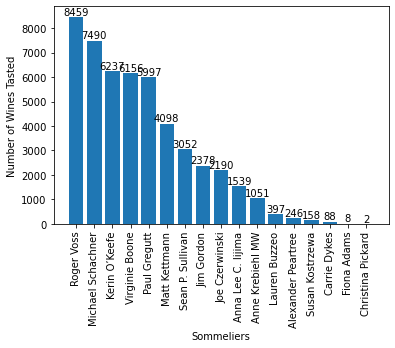

In [6]:
# names of sommeliers and number of wines they tasted
name, count = np.unique(data["taster_name"], return_counts=True)
index = np.argsort(-count)
name = name[index]
count = count[index]
plt.bar(name, count)
for i in range(len(name)):
    plt.annotate(count[i], (i,count[i]), ha="center", va="bottom")
plt.xticks(rotation=90)
plt.xlabel("Sommeliers")
plt.ylabel("Number of Wines Tasted");

In [7]:
# names of wines and number of times they were tasted
wine_tasters = []
wines, counts = np.unique(data.title, return_counts=True)
for i in wines:
    tasters = data[data.title == i].taster_name
    wine_tasters.append(", ".join(np.unique(tasters)))
wine_df = pd.DataFrame({"wines":wines, "counts":counts, "tasters":wine_tasters})
wine_df["taster_counts"] = wine_df.tasters.map(lambda x : x.count(",") + 1)
wine_df.sort_values(["counts", "taster_counts"], ascending=False).head(10)

,wines,counts,tasters,taster_counts
40078,Segura Viudas NV Aria Estate Extra Dry Sparkli...,7,Michael Schachner,1
40083,Segura Viudas NV Extra Dry Sparkling (Cava),7,Michael Schachner,1
39083,Ruinart NV Brut Rosé (Champagne),6,"Joe Czerwinski, Roger Voss",2
2956,Bailly-Lapierre NV Brut (Crémant de Bourgogne),6,Roger Voss,1
20805,Freixenet NV Cordon Negro Extra Dry Sparkling ...,5,Michael Schachner,1
40086,Segura Viudas NV Reserva Heredad Sparkling (Cava),5,Michael Schachner,1
14796,Domaine Charles Baur NV Brut Sparkling (Créman...,4,"Anne Krebiehl MW, Roger Voss",2
23047,Henri Abele NV Brut (Champagne),4,"Paul Gregutt, Roger Voss",2
24568,Jacquart NV Brut Mosaïque (Champagne),4,"Paul Gregutt, Roger Voss",2
36243,Pierre Sparr NV Brut Réserve Sparkling (Créman...,4,"Anne Krebiehl MW, Joe Czerwinski",2


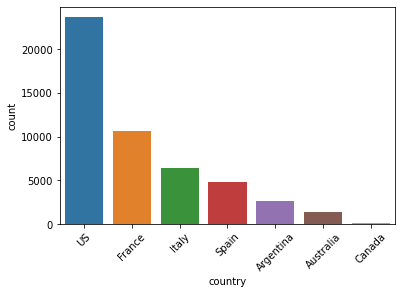

In [8]:
sns.countplot(data=data, x="country", order=data["country"].value_counts().index)
plt.xticks(rotation=45);

In [9]:
for i in np.unique(data["country"]):
    print("There are", np.sum(data["country"] == i), "wines from", i)

There are 2614 wines from Argentina
There are 1358 wines from Australia
There are 155 wines from Canada
There are 10599 wines from France
There are 6382 wines from Italy
There are 4770 wines from Spain
There are 23668 wines from US


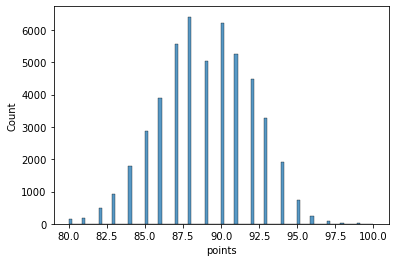

In [10]:
sns.histplot(data=data, x="points");

In [11]:
# look at the wines with a perfect score
data[data["points"] == 100].sort_values("price")

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
id,,,,,,,,,,,
113929,US,In 2005 Charles Smith introduced three high-en...,Royal City,100,80.0,Washington,Columbia Valley (WA),Paul Gregutt,Charles Smith 2006 Royal City Syrah (Columbia ...,Syrah,Charles Smith
123545,US,Initially a rather subdued Frog; as if it has ...,Bionic Frog,100,80.0,Washington,Walla Walla Valley (WA),Paul Gregutt,Cayuse 2008 Bionic Frog Syrah (Walla Walla Val...,Syrah,Cayuse
89728,France,This latest incarnation of the famous brand is...,Cristal Vintage Brut,100,250.0,Champagne,Champagne,Roger Voss,Louis Roederer 2008 Cristal Vintage Brut (Cha...,Champagne Blend,Louis Roederer
36528,France,This is a fabulous wine from the greatest Cham...,Brut,100,259.0,Champagne,Champagne,Roger Voss,Krug 2002 Brut (Champagne),Champagne Blend,Krug
345,Australia,This wine contains some material over 100 year...,Rare,100,350.0,Victoria,Rutherglen,Joe Czerwinski,Chambers Rosewood Vineyards NV Rare Muscat (Ru...,Muscat,Chambers Rosewood Vineyards
45781,Italy,"This gorgeous, fragrant wine opens with classi...",Riserva,100,550.0,Tuscany,Brunello di Montalcino,Kerin O’Keefe,Biondi Santi 2010 Riserva (Brunello di Montal...,Sangiovese,Biondi Santi
89729,France,This new release from a great vintage for Char...,Le Mesnil Blanc de Blancs Brut,100,617.0,Champagne,Champagne,Roger Voss,Salon 2006 Le Mesnil Blanc de Blancs Brut Char...,Chardonnay,Salon


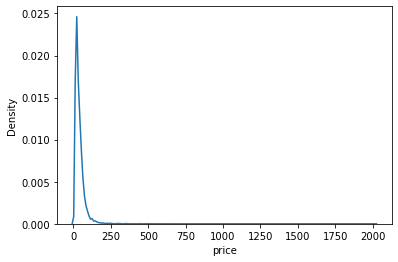

In [12]:
sns.kdeplot(data=data, x="price");

In [13]:
# look at the wines that cost less than $5
data[data["price"] < 5].sort_values(["price", "points"])

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
id,,,,,,,,,,,
117303,Spain,"Tropical fruit and citrus aromas aren't bad, b...",Flirty Bird,82,4.0,Central Spain,Vino de la Tierra de Castilla,Michael Schachner,Felix Solis 2012 Flirty Bird White (Vino de la...,White Blend,Felix Solis
59507,US,"Sweet and fruity, this canned wine feels soft ...",Unoaked,83,4.0,California,California,Jim Gordon,Pam's Cuties NV Unoaked Chardonnay (California),Chardonnay,Pam's Cuties
29553,Argentina,"Crimson in color but also translucent, with a ...",Red,84,4.0,Mendoza Province,Mendoza,Michael Schachner,Broke Ass 2009 Red Malbec-Syrah (Mendoza),Malbec-Syrah,Broke Ass
112919,Spain,"Nice on the nose, this has a leafy note and a ...",Estate Bottled,84,4.0,Levante,Yecla,Michael Schachner,Terrenal 2010 Estate Bottled Tempranillo (Yecla),Tempranillo,Terrenal
1987,Spain,Berry and cherry aromas are surprisingly sturd...,Flirty Bird,85,4.0,Central Spain,Vino de la Tierra de Castilla,Michael Schachner,Felix Solis 2013 Flirty Bird Syrah (Vino de la...,Syrah,Felix Solis


In [14]:
# look at the wines that cost more than $800
data[data["price"] > 800].sort_values(["price", "points"])

,country,description,designation,points,price,province,region_1,taster_name,title,variety,winery
id,,,,,,,,,,,
56959,Australia,Is this the Yin to Grange's Yang? The wines ar...,Hill of Grace,96,820.0,South Australia,Eden Valley,Joe Czerwinski,Henschke 2010 Hill of Grace Shiraz (Eden Valley),Shiraz,Henschke
77028,Australia,This has all the size and weight you've come t...,Grange,98,850.0,South Australia,South Australia,Joe Czerwinski,Penfolds 2008 Grange Shiraz (South Australia),Shiraz,Penfolds
56953,Australia,"This inky, embryonic wine deserves to be cella...",Grange,99,850.0,South Australia,South Australia,Joe Czerwinski,Penfolds 2010 Grange Shiraz (South Australia),Shiraz,Penfolds
120391,US,The nose on this single-vineyard wine from a s...,Roger Rose Vineyard,91,2013.0,California,Arroyo Seco,Matt Kettmann,Blair 2013 Roger Rose Vineyard Chardonnay (Arr...,Chardonnay,Blair


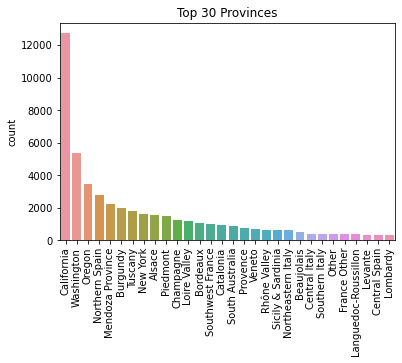

In [15]:
sns.countplot(data=data, x="province", order=data["province"].value_counts().index[:30])
plt.xticks(rotation=90)
plt.xlabel("")
plt.title("Top 30 Provinces");

In [16]:
# find the total number of wines from the Napa / Sonoma area
napa_sonoma = []
for i in np.unique(data["region_1"]):
    if ("Napa" in i) or ("Sonoma" in i):
        napa_sonoma.append(i)
total = np.sum(np.isin(data["region_1"].values, np.array(napa_sonoma)))
print("The number of wines from the Napa / Sonoma area :", total)
percent = total/np.sum(data["province"] == "California")*100
print("This is " + str(round(percent,2)) + "% of the wines from California or " + \
      str(round(total/len(data)*100,2)) + "% of all wines in the dataset.")

The number of wines from the Napa / Sonoma area : 2247
This is 17.65% of the wines from California or 4.54% of all wines in the dataset.


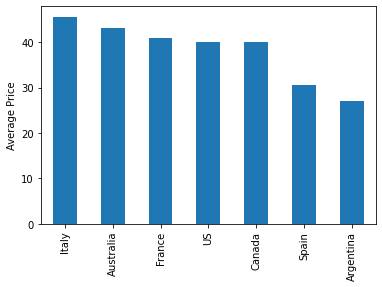

In [17]:
data.groupby("country").mean()["price"].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Average Price")
plt.xlabel("");

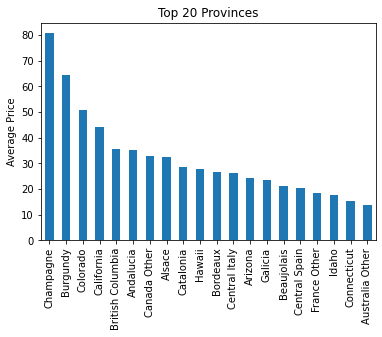

In [18]:
data.groupby("province").mean()["price"][:20].sort_values(ascending=False).plot(kind="bar")
plt.ylabel("Average Price")
plt.xlabel("")
plt.title("Top 20 Provinces");

# Text Preprocessing

In [19]:
# define the corpus as all descriptions
corpus = data.description.values

In [20]:
# define English stop words and add a few wine-related ones
with open("stop_words_english.txt", "r") as f:
    stopwords = [s.strip() for s in f.readlines()]
    
for i in ["wine", "wines", "drink", "drinks", "drank", "drunk", "palate", "palates", "aroma", "aromas",
          "flavor", "flavors", "note", "notes", "finish"]:
    stopwords.append(i)

In [21]:
# clean the corpus
def prep(doc, stemmer=SnowballStemmer("english"), stopwords=stopwords):
    # remove numbers, captial letters and punctuation
    doc = re.sub("\w*\d\w*", " ", doc)
    doc = re.sub("—", " ", doc)
    doc = re.sub('[“”]', " ", doc)
    doc = re.sub("[%s]" % re.escape(string.punctuation), " ", doc.lower())
    doc = doc.split()
    
    # use the stemmer on each word
    final = [stemmer.stem(word) for word in doc if word not in stopwords]
    return " ".join(final)

vfunc = np.vectorize(prep)
corpus = vfunc(corpus)

In [22]:
# twice to catch all the lingering stop words
corpus = vfunc(corpus)

## Count Vectorizer

In [23]:
# create the document-term matrix
cv = CountVectorizer(ngram_range=(1,2), min_df=(2/len(corpus)), max_df=0.4)
x_cv = cv.fit_transform(corpus)
doc_term_cv = pd.DataFrame(x_cv.toarray(), columns=cv.get_feature_names_out())
doc_term_cv.head()

,aaron,aaron jackson,aaron pott,aaron walker,abacela,abad,abandon,abat,abat fetel,abbey,...,zweigelt,zédé,élevag,élévage,émilion,émilion fruiti,über,über aromat,über rich,über simpl
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Term Frequency Inverse Document Frequency

In [24]:
# create the document-term matrix
tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=(2/len(corpus)), max_df=0.4)
x_tfidf = tfidf.fit_transform(corpus)
doc_term_tfidf = pd.DataFrame(x_tfidf.toarray(), columns=tfidf.get_feature_names_out())
doc_term_tfidf.head()

,aaron,aaron jackson,aaron pott,aaron walker,abacela,abad,abandon,abat,abat fetel,abbey,...,zweigelt,zédé,élevag,élévage,émilion,émilion fruiti,über,über aromat,über rich,über simpl
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Topic Modeling

In [25]:
# function to display the top n terms in each topic and their categories
def display_topics(model, feature_names, no_top_words, topic_names=None): 
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("Topic ", ix + 1)
        else:
            print("Topic: ", topic_names[ix])
        print(", ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        print("")

## LSA

Best explained variance ratio 0.12082730337207123 at number of topics 19
The elbow in the graph occurs at number of topics 2


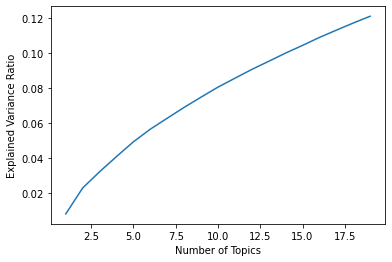

In [26]:
# find the optimal number of topics based on explained variance ratio
evr = []
for i in range(1,20):
    # build an LSA model
    lsa = TruncatedSVD(i)
    lsa.fit(x_cv)
    
    # compute explained variance ratio sum
    evr.append(lsa.explained_variance_ratio_.sum())

# plot the explained variance ratio against number of topics
plt.plot(range(1,20), evr)
plt.xlabel("Number of Topics")
plt.ylabel("Explained Variance Ratio");

print("Best explained variance ratio", max(evr), "at number of topics", np.arange(1,20)[evr == max(evr)][0])
elbow = np.arange(1,20)[np.abs(np.gradient(np.gradient(evr))).argmax()]
print("The elbow in the graph occurs at number of topics", elbow)

In [27]:
# Option 1
# fit the model and display the top terms for each topic
lsa = TruncatedSVD(2)
lsa.fit(x_cv)
display_topics(lsa, cv.get_feature_names_out(), 5)

Topic  1
black, cherri, tannin, acid, ripe

Topic  2
acid, appl, fresh, crisp, lemon



In [28]:
# take a look at the reduced dataframe
doc_topic = lsa.transform(x_cv)
doc_topic_df = pd.DataFrame(doc_topic.round(5), index=data.description)
doc_topic_df.head()

,0,1
description,,
"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",0.19737,0.36040
"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",0.24696,0.03781
"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",1.21643,0.45083
"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",1.68101,0.68883
This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,1.22923,1.56470


## NMF

In [29]:
# Option 2
# fit the model and display the top terms for each topic
nmf = NMF(9, init="nndsvda")
nmf.fit(x_cv)
display_topics(nmf, cv.get_feature_names_out(), 5)

Topic  1
black, black cherri, pepper, black fruit, black pepper

Topic  2
acid, appl, fresh, white, lemon

Topic  3
cabernet, blend, sauvignon, cabernet sauvignon, merlot

Topic  4
red, red fruit, acid, light, red berri

Topic  5
ripe, rich, textur, age, acid

Topic  6
oak, vanilla, toast, bodi, french

Topic  7
cherri, tannin, offer, firm, black cherri

Topic  8
berri, spice, plum, bake, feel

Topic  9
dri, nose, herb, dri herb, fresh



In [30]:
# take a look at the reduced dataframe
doc_topic = nmf.transform(x_cv)
doc_topic_df = pd.DataFrame(doc_topic.round(5), index=data.description)
doc_topic_df.head()

,0,1,2,3,4,5,6,7,8
description,,,,,,,,,
"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",0.00000,0.04093,0.00000,0.00000,0.00000,0.00332,0.00000,0.00134,0.01074
"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",0.00304,0.00311,0.00029,0.00232,0.00432,0.00401,0.00000,0.03007,0.00741
"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",0.00835,0.07562,0.00631,0.01228,0.01617,0.01844,0.01332,0.07443,0.00562
"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",0.00508,0.09821,0.00443,0.12158,0.01098,0.00000,0.04738,0.04168,0.00000
This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,0.00000,0.14696,0.00000,0.00000,0.04037,0.00000,0.00000,0.02856,0.07760


In [31]:
# Option 3
# fit the model and display the top terms for each topic
nmf = NMF(9, init="nndsvda")
nmf.fit(x_tfidf)
display_topics(nmf, tfidf.get_feature_names_out(), 5, ["Black fruit", "Tree fruit", "Varietal wine", "Full body",
                                                       "Red fruit", "Vinification", "Other", "Woody", "Medium body"])

Topic:  Black fruit
black, black cherri, cherri, tannin, pepper

Topic:  Tree fruit
appl, white, lemon, peach, pear

Topic:  Varietal wine
cabernet, cabernet sauvignon, sauvignon, merlot, blend

Topic:  Full body
age, rich, ripe, structur, wood

Topic:  Red fruit
fruiti, red, acid, crisp, soft

Topic:  Vinification
cherri, vineyard, nose, dri, bottl

Topic:  Other
berri, plum, feel, herbal, berri fruit

Topic:  Woody
oak, vanilla, toast, french, french oak

Topic:  Medium body
bodi, medium, medium bodi, textur, sweet



In [32]:
# take a look at the reduced dataframe
doc_topic = nmf.transform(x_tfidf)
doc_topic_df = pd.DataFrame(doc_topic.round(5), index=data.description, columns=["Black fruit", "Tree fruit",
                                                                                 "Varietal wine", "Full body",
                                                                                 "Red fruit", "Vinification",
                                                                                 "Other", "Woody", "Medium body"])
doc_topic_df.head()

,Black fruit,Tree fruit,Varietal wine,Full body,Red fruit,Vinification,Other,Woody,Medium body
description,,,,,,,,,
"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",0.00000,0.02488,0.00000,0.00045,0.00000,0.00585,0.00037,0.00261,0.00098
"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",0.00000,0.00000,0.00000,0.00000,0.00000,0.00840,0.02222,0.00000,0.00256
"Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.",0.00196,0.00776,0.00108,0.00047,0.00554,0.00374,0.03346,0.00000,0.01443
"Here's a bright, informal red that opens with aromas of candied berry, white pepper and savory herb that carry over to the palate. It's balanced with fresh acidity and soft tannins.",0.01495,0.01895,0.00107,0.00000,0.03777,0.00000,0.01056,0.00000,0.00000
This has great depth of flavor with its fresh apple and pear fruits and touch of spice. It's off dry while balanced with acidity and a crisp texture. Drink now.,0.00000,0.04458,0.00000,0.01415,0.03605,0.00395,0.00000,0.00000,0.00663


## LDA

In [33]:
# Option 4
# prepare the corpus for LDA
tokens = [i.split() for i in corpus]
id2word = Dictionary(tokens)
lda_corpus = [id2word.doc2bow(i) for i in tokens]

Best coherence score 0.4697314554107524 at number of topics 4


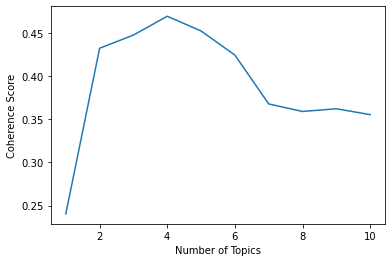

In [34]:
# find the optimal number of topics based on coherence score
coherence_score = []
for i in range(1,11):
    # build an LDA model
    lda_model = LdaModel(corpus=lda_corpus, id2word=id2word, num_topics=i, random_state=0, chunksize=100,
                         alpha="auto", per_word_topics=True, update_every=1, passes=10)
    
    # compute coherence score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=tokens, dictionary=id2word, coherence="c_v")
    coherence_lda = coherence_model_lda.get_coherence()
    coherence_score.append(coherence_lda)

# plot the coherence scores against number of topics
plt.plot(range(1,11), coherence_score)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score");

print("Best coherence score", max(coherence_score), "at number of topics",
      np.arange(1,11)[coherence_score == max(coherence_score)][0])

In [35]:
# build the best LDA model
lda_model = LdaModel(corpus=lda_corpus, id2word=id2word, num_topics=4, random_state=0, chunksize=100,
                     alpha="auto", per_word_topics=True, update_every=1, passes=10)
print(lda_model.print_topics())
doc_lda = lda_model[lda_corpus]

[(0, '0.036*"acid" + 0.034*"fresh" + 0.024*"appl" + 0.022*"light" + 0.020*"crisp" + 0.018*"miner" + 0.016*"lemon" + 0.016*"white" + 0.016*"citrus" + 0.015*"fruiti"'), (1, '0.045*"vineyard" + 0.029*"bottl" + 0.018*"cranberri" + 0.014*"lush" + 0.013*"nose" + 0.012*"grape" + 0.011*"estat" + 0.010*"cola" + 0.010*"tea" + 0.009*"strawberri"'), (2, '0.057*"black" + 0.050*"cherri" + 0.032*"blend" + 0.032*"tannin" + 0.024*"cabernet" + 0.023*"herb" + 0.019*"offer" + 0.019*"pepper" + 0.018*"spice" + 0.018*"dark"'), (3, '0.056*"fruit" + 0.023*"ripe" + 0.018*"rich" + 0.018*"berri" + 0.018*"plum" + 0.018*"oak" + 0.014*"red" + 0.014*"bodi" + 0.013*"age" + 0.012*"spice"')]


In [36]:
# create a document-topic matrix with topic probability distributions
topic1, topic2, topic3, topic4 = [], [], [], []
for i in range(doc_lda.__len__()):
    topic1.append(doc_lda[i][0][0][1])
    topic2.append(doc_lda[i][0][1][1])
    topic3.append(doc_lda[i][0][2][1])
    topic4.append(doc_lda[i][0][3][1])
doc_topic_lda = np.vstack((topic1, topic2, topic3, topic4)).transpose()

## CorEx

In [37]:
# Option 5
# fit the model and force it to have anchored topics
num_topics = 8
anchors = [["white", "lemon", "citrus"], ["cherri", "blackberri", "berri"], ["oak", "vanilla", "toast"],
           ["vineyard", "bottl"], ["cabernet", "sauvignon", "blend", "pinot"], ["structur", "textur"], ["pepper"]]
topic_model = ct.Corex(n_hidden=num_topics, words=cv.get_feature_names_out(), seed=1)
topic_model.fit(x_cv, words=cv.get_feature_names_out(), anchor_strength=5, anchors=anchors, docs=data.description)
topics = topic_model.get_topics()

In [38]:
# print out the topics and words in them
topic_names = ["Citrus Topic", "Berry Topic", "Woody Topic", "Vinification Topic", "Varietal Topic", "Body Topic",
               "Spicy Topic", "Misc Topic"]
for i in range(num_topics):
    print(topic_names[i])
    gather = [topics[i][j][0] for j in range(len(topics[i]))]
    print(", ".join(gather))
    print("")

Citrus Topic
white, citrus, lemon, appl, tannin, lime, peach, grapefruit, zest, plum

Berry Topic
cherri, berri, blackberri, black cherri, pear, red berri, berri fruit, red cherri, cherri fruit, honey

Woody Topic
oak, vanilla, toast, french oak, french, toast oak, barrel, toasti oak, coconut, age french

Vinification Topic
vineyard, bottl, singl vineyard, nose bottl, singl, bottl age, nose, sourc, site, vineyard design

Varietal Topic
blend, cabernet, sauvignon, pinot, cabernet sauvignon, merlot, cabernet franc, franc, pinot noir, petit

Body Topic
textur, structur, age, rich, ripe, fruiti, wood age, readi, aftertast, charact

Spicy Topic
pepper, black, black pepper, white pepper, licor, underbrush, clove, crush, offer, deliv

Misc Topic
bodi, medium, medium bodi, linger, long, complex, color, now, lush, sen



In [39]:
# create the doc-topic dataframe
predictions = pd.DataFrame(topic_model.labels, columns=topic_names, index=data.index)
for i in topic_names:
    predictions[i] = predictions[i]
predictions.head()

,Citrus Topic,Berry Topic,Woody Topic,Vinification Topic,Varietal Topic,Body Topic,Spicy Topic,Misc Topic
id,,,,,,,,
3,True,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False
5,False,True,False,False,False,False,False,False
6,True,True,False,False,False,False,True,False
9,False,False,False,False,False,True,False,False


In [40]:
# calculate how the topics are distributed
for i in topic_names:
    percent = np.sum(predictions[i]) / predictions.shape[0]
    print("Percent", i, "Documents :", percent)

Percent Citrus Topic Documents : 0.2790336253178864
Percent Berry Topic Documents : 0.4108101562184637
Percent Woody Topic Documents : 0.23578089048560932
Percent Vinification Topic Documents : 0.19930973236991886
Percent Varietal Topic Documents : 0.21137932426432002
Percent Body Topic Documents : 0.273402494651435
Percent Spicy Topic Documents : 0.17452468413191782
Percent Misc Topic Documents : 0.3580309207605054


# Recommender Systems

In [41]:
# find the wine closest to the indicated one
def close_match(new_coords, wine_index, data):
    dist = pairwise_distances(new_coords[wine_index].reshape(1,-1), new_coords)
    closest = dist.argsort()[0][1]
    print("Wine to Match")
    print("")
    print("Title:")
    print(data.title.values[wine_index])
    print("")
    print("Description:")
    print(data.description.values[wine_index])
    print("")
    print("")
    print("")
    print("Closest Match")
    print("")
    print("Title:")
    print(data.title.values[closest])
    print("")
    print("Description:")
    print(data.description.values[closest])
    return closest

In [42]:
# take user input related to the details of the wine
def user_input(pred, df, wine_index, country=None, points=None, price=None, province=None, variety=None, winery=None):
    if country:
        pred = pred[df.country == country]
        df = df[df.country == country]
    if province:
        pred = pred[df.province == province]
        df = df[df.province == province]
    if variety:
        pred = pred[df.variety == variety]
        df = df[df.variety == variety]
    if winery:
        pred = pred[df.winery == winery]
        df = df[df.winery == winery]
    if points:
        pred = pred[(df.points >= points[0]) & (df.points <= points[1])]
        df = df[(df.points >= points[0]) & (df.points <= points[1])]
    if price:
        pred = pred[(df.price >= price[0]) & (df.price <= price[1])]
        df = df[(df.price >= price[0]) & (df.price <= price[1])]
    pred = pred.to_numpy(dtype="int")
    closest = close_match(pred, wine_index, df)
    return df.iloc[[wine_index, closest]][["title", "country", "points", "price", "province", "variety", "winery"]]

## Content-based Filtering

In [43]:
close_match(predictions.to_numpy(dtype="int"), 2, data);

Wine to Match

Title:
Tandem 2011 Ars In Vitro Tempranillo-Merlot (Navarra)

Description:
Blackberry and raspberry aromas show a typical Navarran whiff of green herbs and, in this case, horseradish. In the mouth, this is fairly full bodied, with tomatoey acidity. Spicy, herbal flavors complement dark plum fruit, while the finish is fresh but grabby.



Closest Match

Title:
Menduco 2011 Reserve Malbec (Uco Valley)

Description:
Concentrated blackberry and black currant aromas are ripe and come with a balsamic note. It feels juicy, full, lively and fresh, with oaky dark-plum flavors accented by rooty, herbal notes. Dry tannins mark the finish.


In [44]:
user_input(predictions, data, 16, country="US", price=[0,80], variety="Cabernet Sauvignon")

Wine to Match

Title:
Truchard 2012 Estate Cabernet Sauvignon (Carneros)

Description:
From a knoll in Carneros, oft thought of as chilly for Cabernet, this wine exhibits cooler aspects of the variety, from pencil lead and cedar to dried herb. It is complemented by fruitier characteristics of cassis and plum, finishing in dusty, structured tannins. Cellar through 2017–2020.



Closest Match

Title:
Sleight of Hand 2010 The Illusionist Cabernet Sauvignon (Columbia Valley (WA))

Description:
This is mostly Cabernet Sauvignon, with Petit Verdot and Cabernet Franc making up the last 9%. Smooth, supple and satiny on the palate, this wine is bursting with scents and flavors of deep purple fruit, cassis, smoke and graphite. The polished, lightly textured tannins add a sense of muscle to the finish. This is a wine that may be gulped down immediately, or cellared for up to a decade.


,title,country,points,price,province,variety,winery
id,,,,,,,
674,Truchard 2012 Estate Cabernet Sauvignon (Carne...,US,90,38.0,California,Cabernet Sauvignon,Truchard
98560,Sleight of Hand 2010 The Illusionist Cabernet ...,US,94,52.0,Washington,Cabernet Sauvignon,Sleight of Hand


## Collaborative Filtering

In [45]:
# create a user_item matrix
ratings = pd.pivot_table(data, index="taster_name", columns="title", values="points")
ratings.tail(3)

title,1+1=3 2008 Rosé Cabernet Sauvignon (Penedès),1+1=3 NV Brut Sparkling (Cava),1+1=3 NV Cygnus Brut Nature Reserva Made With Organic Grapes Sparkling (Cava),1+1=3 NV Rosé Sparkling (Cava),100 Percent Wine 2012 All Profits to Charity Red (California),100 Percent Wine 2014 All Profits to Charity Sauvignon Blanc (California),1000 Stories 2013 Bourbon Barrel Aged Zinfandel (Mendocino),1000 Stories 2014 Bourbon Barrel Aged Batch No 13 Zinfandel (California),12 Linajes 2000 Reserva (Ribera del Duero),12 Linajes 2009 Reserva (Ribera del Duero),...,àMaurice 2012 William Ivey Red (Columbia Valley (WA)),àMaurice 2013 Anne Martin McCool Red (Columbia Valley (WA)),àMaurice 2013 Fred Estate Syrah (Walla Walla Valley (WA)),àMaurice 2013 Night Owl Estate Red (Walla Walla Valley (WA)),àMaurice 2013 Owl & Crown Estate Reserve Cabernet Sauvignon (Walla Walla Valley (WA)),àMaurice 2013 Sparrow Estate Viognier Viognier (Walla Walla Valley (WA)),àMaurice 2014 Boushey Vineyard Marsanne-Viognier (Yakima Valley),àMaurice 2014 Boushey Vineyard Syrah (Yakima Valley),àMaurice 2014 Fred Estate Syrah (Walla Walla Valley (WA)),àMaurice NV Pour Me Red (Columbia Valley (WA))
taster_name,,,,,,,,,,,,,,,,,,,,,
Sean P. Sullivan,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,91.0,91.0,89.0,90.0,90.0,91.0,89.0,89.0,88.0,NaN
Susan Kostrzewa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Virginie Boone,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# convert to a sparse matrix
sparse = scipy.sparse.csr_matrix(ratings.fillna(0).values)
sparse = coo_matrix(sparse)

In [47]:
# fit the model
model = LightFM(loss="warp", no_components=175)
model.fit(sparse, epochs=100, num_threads=6)

In [48]:
# calculate the error
users, items = sparse.shape
scores = np.array([model.predict(int(i), np.arange(items)) for i in np.arange(users)])
error = pd.DataFrame(np.abs(ratings - scores))
np.mean(error.mean())

89.33126031173249

This error is about the same as the average points given to each wine, which tells me the predictions are all roughly zero and this method is not viable. Since practically only one person has tasted each wine, none of the tasters have anything in common and the matrix is far too sparse.

## Hybrid Recommender

In [49]:
# fit the model
model = LightFM(loss="warp", no_components=175)
model.fit(sparse, epochs=100, num_threads=6, item_features=coo_matrix(x_cv))

In [50]:
# calculate the error
users, items = sparse.shape
scores = np.array([model.predict(int(i), np.arange(items), item_features=coo_matrix(x_cv)) for i in np.arange(users)])
error = pd.DataFrame(np.abs(ratings - scores))
np.mean(error.mean())

92.26514227406736

In [51]:
def recommendation(model, coo_data, user_ids, data, features):
    for user_id in user_ids:
        scores = model.predict(user_id, np.arange(coo_data.shape[1]), item_features=features)
        top_items = data.title.unique()[np.argsort(-scores)]
        print("Taster : " + data.taster_name.unique()[user_id])
        print("Top Wine Suggestion : \n" + top_items[0])
        print("")

In [52]:
recommendation(model, sparse, [4, 2], data, coo_matrix(x_cv))

Taster : Roger Voss
Top Wine Suggestion : 
Mommessin 2014 Grandes Mises  (Saint-Amour)

Taster : Michael Schachner
Top Wine Suggestion : 
Chateau Rollat 2011 Edouard Cabernet Sauvignon (Walla Walla Valley (WA))

